<a href="https://colab.research.google.com/github/ArunDharavath/ML-projects/blob/main/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing all required packages

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

Loading the Dataset

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteF2ZMUM/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteF2ZMUM/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Preprocess the dataset

In [4]:
def resize(inp_img, inp_mask):
    inp_img = tf.image.resize(inp_img, (128, 128), method="nearest")
    inp_mask = tf.image.resize(inp_mask, (128, 128), method="nearest")

    return inp_img, inp_mask 

In [5]:
def augment(inp_img, inp_mask):
    if tf.random.uniform(()) > 0.5:
        inp_img = tf.image.flip_left_right(inp_img)
        inp_mask = tf.image.flip_left_right(inp_mask)

    return inp_img, inp_mask

In [6]:
def normalize(inp_img, inp_mask):
   inp_img = tf.cast(inp_img, tf.float32) / 255.0
   inp_mask -= 1
   return inp_img, inp_mask

Splitting dataset into train and test

In [7]:
def load_image_train(datapoint):
   inp_img = datapoint["image"]
   inp_mask = datapoint["segmentation_mask"]
   inp_img, inp_mask = resize(inp_img, inp_mask)
   inp_img, inp_mask = augment(inp_img, inp_mask)
   inp_img, inp_mask = normalize(inp_img, inp_mask)

   return inp_img, inp_mask

def load_image_test(datapoint):
   inp_img = datapoint["image"]
   inp_mask = datapoint["segmentation_mask"]
   inp_img, inp_mask = resize(inp_img, inp_mask)
   inp_img, inp_mask = normalize(inp_img, inp_mask)

   return inp_img, inp_mask

In [8]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

Creating batches

In [9]:

BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

Visualization of example image

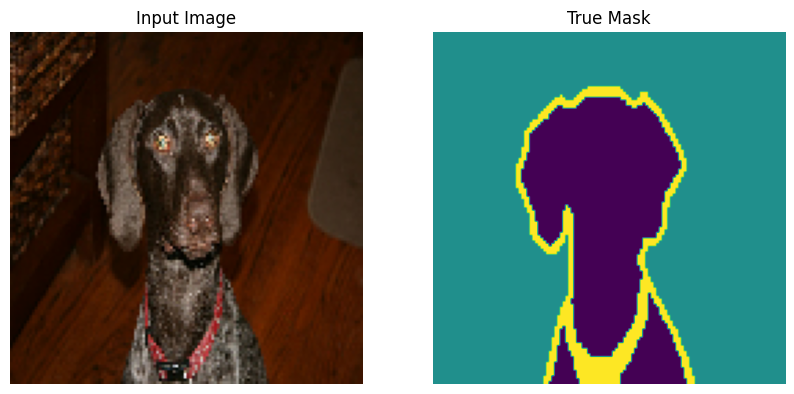

In [10]:
def display(display_list):
 plt.figure(figsize=(10, 10))
 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_img, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_img, sample_mask])

Defining the Model Architecture: encoder, decoder and convolution

In [11]:
def double_conv_block(x, num_filters):
  x = layers.Conv2D(num_filters, 3, padding="same", activation="relu", kernel_initializer='he_normal')(x)
  x = layers.Conv2D(num_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
  return x

In [12]:
def downsample_block(x, num_filters):
    f = double_conv_block(x, num_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [13]:
def upsample_block(x, conv_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, num_filters)

    return x

In [14]:
def build_unet():
  inputs = layers.Input(shape=(128, 128, 3))

  e1, p1 = downsample_block(inputs, 64)
  e2, p2 = downsample_block(p1, 128)
  e3, p3 = downsample_block(p2, 256)
  e4, p4 = downsample_block(p3, 512)
  bottleneck = double_conv_block(p4, 1024)
  d1 = upsample_block(bottleneck, e4, 512)
  d2 = upsample_block(d1, e3, 256)
  d3 = upsample_block(d2, e2, 128)
  d4 = upsample_block(d3, e1, 64)

  op = layers.Conv2D(3, 1, padding="same", activation="softmax")(d4)

  unet_model = tf.keras.Model(inputs, op, name="U-Net")

  return unet_model

In [15]:
unet_model = build_unet()
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

Compiling and running the model

In [39]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics="accuracy")

In [40]:
NUM_EPOCHS = 5

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches, epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches)

Epoch 1/5
57/57 [==============================] - 70s 995ms/step - loss: 0.6737 - accuracy: 0.7294 - val_loss: 0.6114 - val_accuracy: 0.7548
Epoch 2/5
57/57 [==============================] - 57s 1s/step - loss: 0.5939 - accuracy: 0.7652 - val_loss: 0.5813 - val_accuracy: 0.7670
Epoch 3/5
57/57 [==============================] - 56s 989ms/step - loss: 0.5142 - accuracy: 0.7996 - val_loss: 0.4962 - val_accuracy: 0.8090
Epoch 4/5
57/57 [==============================] - 57s 1s/step - loss: 0.4738 - accuracy: 0.8172 - val_loss: 0.4462 - val_accuracy: 0.8270
Epoch 5/5
57/57 [==============================] - 56s 990ms/step - loss: 0.4344 - accuracy: 0.8337 - val_loss: 0.4159 - val_accuracy: 0.8394


Prediction phase

In [56]:
def compute_iou(pred_mask, true_mask):
  intersection = np.sum(np.logical_and(pred_mask, true_mask))
  union = np.sum(np.logical_or(pred_mask, true_mask))
  iou = intersection / union
  return iou

In [66]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]

 return pred_mask

def show_predictions(dataset=None, num=2):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     pred_mask = create_mask(pred_mask)

     pred_mask = pred_mask[0].numpy()
     true_mask = mask[0].numpy()

     iou = compute_iou(pred_mask, true_mask)
     print("IoU score: ", iou * 100)

     display([image[0], mask[0], pred_mask])
 else:
   display([sample_image, sample_mask,
            create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

2/2 [==============================] - 0s 175ms/step
IoU score:  57.446808510638306


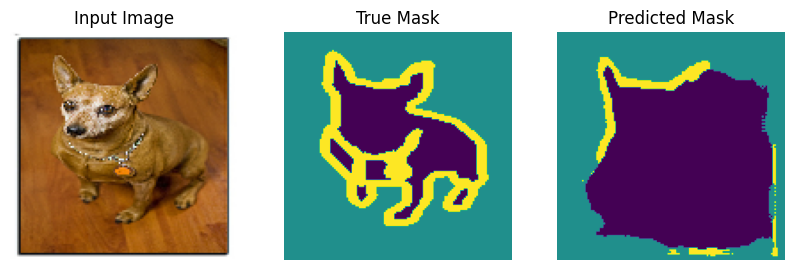

2/2 [==============================] - 0s 120ms/step
IoU score:  88.0319661082226


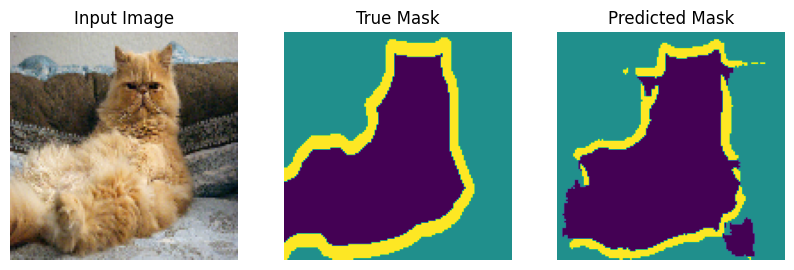

2/2 [==============================] - 0s 112ms/step
IoU score:  88.10850084766287


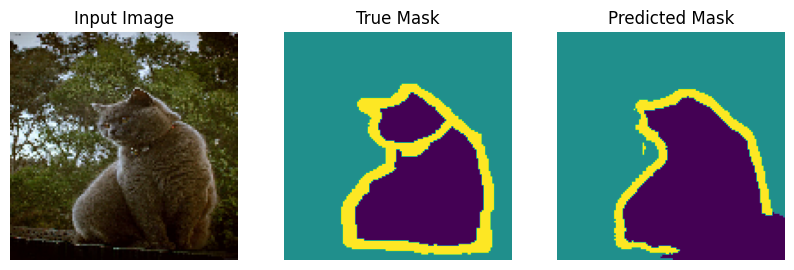

In [68]:
show_predictions(test_batches, 3)